In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle
import os
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pathlib import Path
from sklearn.exceptions import ConvergenceWarning
import warnings

In [2]:
def write_prediction_to_file(df, file_name):
    df.to_csv(file_name, index=False, quoting=csv.QUOTE_ALL)

def sembed_union(df, file_path):
    numpy = np.load(file_path)

    conv_row = np.size(numpy, axis=0)
    conv_col = np.size(numpy, axis=1)

    x = range(conv_row)
    y = range(conv_col)
    sembed_column_names = []

    for j in y:
            sembed_column_names.append("conv{}".format(j+1))
    # Returns dataframe of sentence embedding
    conv_df = pd.DataFrame(numpy, columns=sembed_column_names)
    print(type(conv_df))
    print(type(df))
    return pd.concat([df, conv_df], sort=False, axis=1)

def save_model(file_name, model):
    with open(file_name+".pkl", 'wb') as file:
        pickle.dump(model, file)

def load_model(file_name):
    file_path = Path(file_name+".pkl")
    
    if file_path.exists():
        with open(file_name+".pkl", 'rb') as file:
            return pickle.load(file)
    else:
        return None
    
def evaluate_models(models, X, y):
    for model_name, model in models.items():
        print(f"Results for {model_name}:")
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap='Blues')
        plt.title(model_name)
        plt.show()
        print(classification_report(y, y_pred, zero_division=0))
        print(f"Best parameters: {model.get_params()}")
        print("="*60)


def create_best_classifiers(models, param_grid, X, y):
    best_models = {}
    for model_name, model in models.items():
        if not load_model(model_name):
            print("Training: ", model_name)
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], 
                                    cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1, refit=True)
            grid_search.fit(X, y)
            best_models[model_name] = grid_search.best_estimator_
            save_model(model_name, grid_search.best_estimator_)
            results = grid_search.cv_results_
            
            for mean_score, std_score, params in zip(results["mean_test_score"], results["std_test_score"], results["params"]):
                print(f"Mean Score: {mean_score:.3f}, Std Score: {std_score:.3f}, Parameters: {params}")
        else:
            print("Exists: ", model_name)
            best_models[model_name] = load_model(model_name)
    
    # Evaluate models
    evaluate_models(best_models, X, y)

    return best_models

def predict_test(models, case_id, X, suffix, record):
    file_path = 'Predictions/'
    file_type = '.csv'
    for model_name, model in models.items():
        pred = model.predict(X)
        output_df = pd.DataFrame({
            'case_id': case_id,  # Replace 'Index' with a unique identifier if available
            'successful_appeal': pred
        })
        if record:
            output_df.to_csv(file_path+model_name+"_"+suffix+file_type, index=False)
    return None

def voting_classifier(models, X, y):
    print("Voting Classifier Train")
    estimators = []
    for model_name, model in models.items():
        estimators.append((model_name, model))
    print(estimators)
    voting_clf_hard = VotingClassifier(estimators=estimators,
                                  voting='hard')
    voting_clf_soft = VotingClassifier(estimators=estimators,
                                  voting='soft')
    voting_clf_hard.fit(X, y)
    voting_clf_soft.fit(X, y)
    save_model("VotingClassifierHard", voting_clf_hard)
    save_model("VotingClassifierSoft", voting_clf_soft)
    models["VotingClassifierHard"] = voting_clf_hard
    models["VotingClassifierSoft"] = voting_clf_soft

    return models

def extract_datefields(df):
    date_fields = ['argument_date']
    
    df[date_fields] = df[date_fields].apply(pd.to_datetime)
    
    df['argument_year'] = df['argument_date'].dt.year
    df['argument_month'] = df['argument_date'].dt.month
    df['argument_day'] = df['argument_date'].dt.day
    
    return df

def extract_datefields_difference(df):
    date_fields = ['argument_date', 'decision_date']
    
    df[date_fields] = df[date_fields].apply(pd.to_datetime)
    
    df['argument_year'] = df['argument_date'].dt.year
    df['argument_month'] = df['argument_date'].dt.month
    df['argument_day'] = df['argument_date'].dt.day

    df['decision_year'] = df['decision_date'].dt.year
    df['decision_month'] = df['decision_date'].dt.month
    df['decision_day'] = df['decision_date'].dt.day

    df['days_until_decision'] = (df['decision_date'] - df['argument_date']).dt.days
    
    return df

In [3]:
nltk_data_path = os.path.expanduser('~') + '/nltk_data/'

if not os.path.exists(nltk_data_path + 'corpora/stopwords'):
    nltk.download('stopwords', quiet=True)  # 'quiet=True' to suppress messages
if not os.path.exists(nltk_data_path + 'corpora/wordnet'):
    nltk.download('wordnet', quiet=True)

stop_words = (stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

warnings.filterwarnings("ignore", category=ConvergenceWarning)

df = pd.read_json("data/train.jsonl", lines=True)
df_dev = pd.read_json("data/dev.jsonl", lines=True)
df_test = pd.read_json("data/test.jsonl", lines=True)

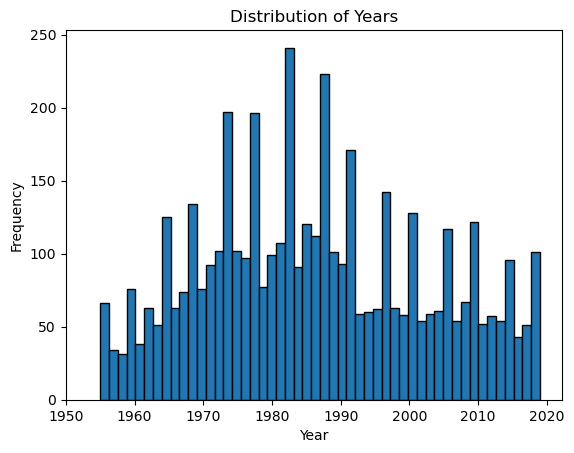

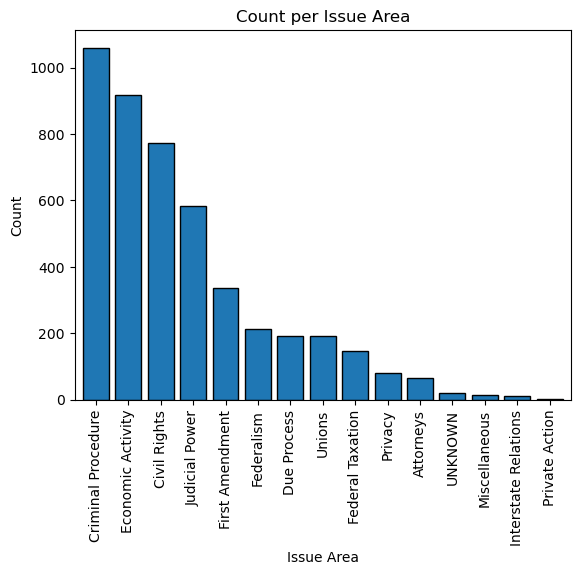

In [4]:
# Data Setup

use_features_list = ["petitioner_category", "respondent_category", 
                    "issue_area", "year", "court_hearing_length", "utterances_number", "argument_date"]

# use_features_list = ["petitioner_category", "respondent_category", 
#                    "issue_area", "year", "court_hearing_length", "utterances_number", "argument_date", "decision_date", "majority_ratio"]

train_df = df[use_features_list]
train_labels = df['successful_appeal']

eval_df = df_dev[use_features_list]
eval_labels = df_dev['successful_appeal']

test_df = df_test[use_features_list]
test_df_id = df_test['case_id']

# Distribution of case years

plt.hist(train_df['year'], bins=50, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Years')
plt.xticks(ticks=range(1950, 2030, 10))

plt.show()


value_counts = df['issue_area'].value_counts()
value_counts.plot(kind='bar', edgecolor='black', width=0.8)
# Add labels and title
plt.xlabel('Issue Area')
plt.ylabel('Count')
plt.title('Count per Issue Area')

# Show plot
plt.show()


In [5]:
imp_majority = SimpleImputer(missing_values="UNKNOWN", strategy="most_frequent")

train_df.loc[:, 'issue_area'] = imp_majority.fit_transform(train_df[['issue_area']])
eval_df.loc[:, 'issue_area'] = imp_majority.transform(eval_df[['issue_area']])
test_df.loc[:, 'issue_area'] = imp_majority.transform(test_df[['issue_area']])

train_df

,petitioner_category,respondent_category,issue_area,year,court_hearing_length,utterances_number,argument_date
0,railroad,"employee, or job applicant, including benefici...",Economic Activity,1993,3349.126,199,2/28/1994
1,United States,governmental employee or job applicant,Judicial Power,1981,2658.159,73,2/23/1982
2,debtor,"bank, savings and loan, credit union, investme...",Civil Rights,2011,3510.266,225,4/23/2012
3,"prisoner, inmate of penal institution",State,Due Process,2015,3603.375,276,2/29/2016
4,"attorney, or person acting as such;includes ba...",state or U.S. supreme court,Attorneys,1981,3319.019,243,11/9/1981
...,...,...,...,...,...,...,...
4607,"military personnel, or dependent of, including...",employer. If employer's relations with employe...,Civil Rights,1980,3473.217,282,3/4/1981
4608,person convicted of crime,United States,Criminal Procedure,2006,3540.562,220,11/7/2006
4609,Federal Trade Commission,"mining company or miner, excluding coal, oil, ...",Economic Activity,1956,6304.297,380,12/12/1956
4610,"National Labor Relations Board, or regional of...","union, labor organization, or official of",Judicial Power,1987,3747.295,199,10/5/1987


In [6]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

ohetransform = ohe.fit_transform(train_df[['issue_area']])
train_df = pd.concat([train_df, ohetransform], axis = 1).drop(columns = ['issue_area'] )

ohetransform = ohe.transform(eval_df[['issue_area']])
eval_df = pd.concat([eval_df, ohetransform], axis = 1).drop(columns = ['issue_area'] )

ohetransform = ohe.transform(test_df[['issue_area']])
test_df = pd.concat([test_df, ohetransform], axis = 1).drop(columns = ['issue_area'] )

train_df

,petitioner_category,respondent_category,year,court_hearing_length,utterances_number,argument_date,issue_area_Attorneys,issue_area_Civil Rights,issue_area_Criminal Procedure,issue_area_Due Process,issue_area_Economic Activity,issue_area_Federal Taxation,issue_area_Federalism,issue_area_First Amendment,issue_area_Interstate Relations,issue_area_Judicial Power,issue_area_Miscellaneous,issue_area_Privacy,issue_area_Private Action,issue_area_Unions
0,railroad,"employee, or job applicant, including benefici...",1993,3349.126,199,2/28/1994,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,United States,governmental employee or job applicant,1981,2658.159,73,2/23/1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,debtor,"bank, savings and loan, credit union, investme...",2011,3510.266,225,4/23/2012,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"prisoner, inmate of penal institution",State,2015,3603.375,276,2/29/2016,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"attorney, or person acting as such;includes ba...",state or U.S. supreme court,1981,3319.019,243,11/9/1981,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,"military personnel, or dependent of, including...",employer. If employer's relations with employe...,1980,3473.217,282,3/4/1981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4608,person convicted of crime,United States,2006,3540.562,220,11/7/2006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4609,Federal Trade Commission,"mining company or miner, excluding coal, oil, ...",1956,6304.297,380,12/12/1956,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4610,"National Labor Relations Board, or regional of...","union, labor organization, or official of",1987,3747.295,199,10/5/1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
# Text Preprocessing

petcat_vector_training = train_df['petitioner_category']
rescat_vector_training = train_df['respondent_category']

petcat_vector_eval = eval_df['petitioner_category']
rescat_vector_eval = eval_df['respondent_category']

petcat_vector_test = test_df['petitioner_category']
rescat_vector_test = test_df['respondent_category']

analyzer = TfidfVectorizer().build_analyzer()

def lemmatized_words(doc):
    return (lemmatizer.lemmatize(w) for w in analyzer(doc) if w not in stop_words)

tfid_vectorizer = TfidfVectorizer(lowercase=True, analyzer=lemmatized_words, max_features=100)

tfid_petcat_training = tfid_vectorizer.fit_transform(petcat_vector_training)
petcat_col_training = pd.DataFrame(tfid_petcat_training.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("petcat_")
tfid_petcat_eval = tfid_vectorizer.transform(petcat_vector_eval)
petcat_col_eval = pd.DataFrame(tfid_petcat_eval.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("petcat_")
tfid_petcat_test = tfid_vectorizer.transform(petcat_vector_test)
petcat_col_test = pd.DataFrame(tfid_petcat_test.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("petcat_")

tfid_rescat_training = tfid_vectorizer.fit_transform(rescat_vector_training)
rescat_col_training = pd.DataFrame(tfid_rescat_training.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("rescat_")
tfid_rescat_eval = tfid_vectorizer.transform(rescat_vector_eval)
rescat_col_eval = pd.DataFrame(tfid_rescat_eval.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("rescat_")
tfid_rescat_test = tfid_vectorizer.transform(rescat_vector_test)
rescat_col_test = pd.DataFrame(tfid_rescat_test.toarray(), columns=tfid_vectorizer.get_feature_names_out()).add_prefix("rescat_")

train_df = pd.concat([train_df, petcat_col_training, rescat_col_training], axis=1).drop(columns = ['respondent_category','petitioner_category'] )
eval_df = pd.concat([eval_df, petcat_col_eval, rescat_col_eval], axis=1).drop(columns = ['respondent_category','petitioner_category'] )
test_df = pd.concat([test_df, petcat_col_test, rescat_col_test], axis=1).drop(columns = ['respondent_category','petitioner_category'] )



train_df

,year,court_hearing_length,utterances_number,argument_date,issue_area_Attorneys,issue_area_Civil Rights,issue_area_Criminal Procedure,issue_area_Due Process,issue_area_Economic Activity,issue_area_Federal Taxation,...,rescat_township,rescat_tribe,rescat_union,rescat_unit,rescat_united,rescat_used,rescat_village,rescat_voter,rescat_well,rescat_wrongful
0,1993,3349.126,199,2/28/1994,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1981,2658.159,73,2/23/1982,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2011,3510.266,225,4/23/2012,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.558271,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,2015,3603.375,276,2/29/2016,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,1981,3319.019,243,11/9/1981,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,1980,3473.217,282,3/4/1981,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.185677,0.0,0.0,0.0,0.0
4608,2006,3540.562,220,11/7/2006,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.814856,0.000000,0.0,0.0,0.0,0.0
4609,1956,6304.297,380,12/12/1956,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4610,1987,3747.295,199,10/5/1987,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.559282,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [8]:
train_df = extract_datefields(train_df).drop(columns = ['argument_date'])
eval_df = extract_datefields(eval_df).drop(columns = ['argument_date'])
test_df = extract_datefields(test_df).drop(columns = ['argument_date'])

# train_df = extract_datefields_difference(train_df).drop(columns = ['argument_date', 'decision_date'])
# eval_df = extract_datefields_difference(eval_df).drop(columns = ['argument_date', 'decision_date'])
# test_df = extract_datefields_difference(test_df).drop(columns = ['argument_date', 'decision_date'])

train_df

,year,court_hearing_length,utterances_number,issue_area_Attorneys,issue_area_Civil Rights,issue_area_Criminal Procedure,issue_area_Due Process,issue_area_Economic Activity,issue_area_Federal Taxation,issue_area_Federalism,...,rescat_unit,rescat_united,rescat_used,rescat_village,rescat_voter,rescat_well,rescat_wrongful,argument_year,argument_month,argument_day
0,1993,3349.126,199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1994,2,28
1,1981,2658.159,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1982,2,23
2,2011,3510.266,225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2012,4,23
3,2015,3603.375,276,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2016,2,29
4,1981,3319.019,243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1981,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,1980,3473.217,282,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.185677,0.0,0.0,0.0,0.0,1981,3,4
4608,2006,3540.562,220,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.814856,0.000000,0.0,0.0,0.0,0.0,2006,11,7
4609,1956,6304.297,380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1956,12,12
4610,1987,3747.295,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1987,10,5


In [9]:
# Iterative Imputer

iter_imputer = IterativeImputer(max_iter=20, random_state=1)

train_array = iter_imputer.fit_transform(train_df)
eval_array = iter_imputer.transform(eval_df)
test_array = iter_imputer.transform(test_df)

train_df = pd.DataFrame(train_array, columns=train_df.columns)
eval_df = pd.DataFrame(eval_array, columns=eval_df.columns)
test_df = pd.DataFrame(test_array, columns=test_df.columns)

train_df

,year,court_hearing_length,utterances_number,issue_area_Attorneys,issue_area_Civil Rights,issue_area_Criminal Procedure,issue_area_Due Process,issue_area_Economic Activity,issue_area_Federal Taxation,issue_area_Federalism,...,rescat_unit,rescat_united,rescat_used,rescat_village,rescat_voter,rescat_well,rescat_wrongful,argument_year,argument_month,argument_day
0,1993.0,3349.126,199.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1994.0,2.0,28.0
1,1981.0,2658.159,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1982.0,2.0,23.0
2,2011.0,3510.266,225.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2012.0,4.0,23.0
3,2015.0,3603.375,276.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2016.0,2.0,29.0
4,1981.0,3319.019,243.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1981.0,11.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,1980.0,3473.217,282.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.185677,0.0,0.0,0.0,0.0,1981.0,3.0,4.0
4608,2006.0,3540.562,220.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.814856,0.000000,0.0,0.0,0.0,0.0,2006.0,11.0,7.0
4609,1956.0,6304.297,380.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1956.0,12.0,12.0
4610,1987.0,3747.295,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1987.0,10.0,5.0


In [10]:
# Select K Best

selector = SelectKBest(f_classif, k=200)
kbest = selector.fit(train_df, y=train_labels)
selected_features = train_df.columns[kbest.get_support()]

train_df = pd.DataFrame(kbest.transform(train_df), columns=selected_features)
eval_df = pd.DataFrame(kbest.transform(eval_df), columns=selected_features)
test_df = pd.DataFrame(kbest.transform(test_df), columns=selected_features)

In [11]:
feature_scores = selector.scores_
scores = pd.DataFrame(columns=['Feature', 'Score'])
for feature, score in zip(train_df.columns, feature_scores):
    row = pd.DataFrame([{'Feature' : feature, 'Score' : score }])
    scores = pd.concat([scores, row], ignore_index=True)

scores.to_csv("KBestScores.csv", index=False)
scores

C:\Users\apple\AppData\Local\Temp\ipykernel_62372\3488739686.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores = pd.concat([scores, row], ignore_index=True)


,Feature,Score
0,year,0.555701
1,court_hearing_length,1.519206
2,utterances_number,0.739806
3,issue_area_Attorneys,0.077986
4,issue_area_Civil Rights,4.339958
...,...,...
195,rescat_village,7.754718
196,rescat_voter,0.003922
197,rescat_wrongful,0.088499
198,argument_year,15.660076


In [12]:
# Feature Scaling

feature_scaler = StandardScaler()

X_scaled_train = feature_scaler.fit_transform(train_df)
y_scaled_train = train_labels

X_scaled_eval = feature_scaler.transform(eval_df)
y_scaled_eval = eval_labels

X_scaled_test = feature_scaler.transform(test_df)

In [13]:
zero_R_clf = DummyClassifier(strategy="most_frequent")
zero_R_clf.fit(X_scaled_train, y_scaled_train)

zero_R_pred_y = zero_R_clf.predict(X_scaled_eval)
zero_R_accuracy = accuracy_score(y_pred = zero_R_pred_y, y_true = y_scaled_eval)
print("Zero-R Accuracy Training: ",(zero_R_accuracy * 100))

Zero-R Accuracy Training:  63.60485268630849


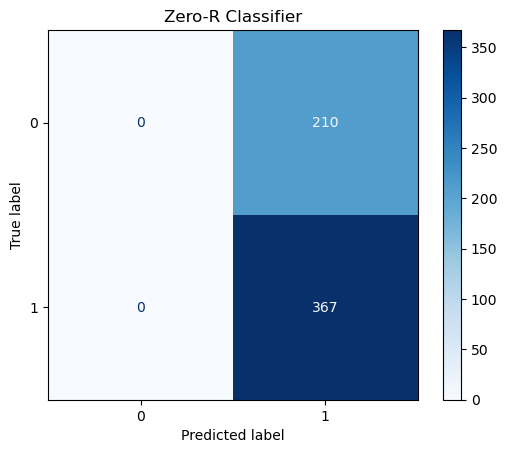

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       210
           1       0.64      1.00      0.78       367

    accuracy                           0.64       577
   macro avg       0.32      0.50      0.39       577
weighted avg       0.40      0.64      0.49       577



In [14]:
cm = confusion_matrix(y_scaled_eval, zero_R_pred_y, labels=zero_R_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=zero_R_clf.classes_)
disp.plot(cmap='Blues')
plt.title("Zero-R Classifier")
plt.show()

print(classification_report(y_scaled_eval, zero_R_pred_y, zero_division=0))
print("="*60)

In [15]:
# Models to be trained
models = {
    'RandomForest': RandomForestClassifier(random_state=1),
    'MLPClassifier': MLPClassifier(random_state=1, learning_rate_init=0.01, early_stopping=True)
}


In [16]:
# Parameter grid for hyperparameter learning
param_grid = {
    'RandomForest': {'n_estimators': [50, 100, 200, 300], 'max_depth': [5, 10, 20, 30]},
    'MLPClassifier': {'max_iter': [500, 700, 900], 'activation': ['relu','logistic','tanh'], 'alpha': [0.001, 0.01, 0.1], 
                      'hidden_layer_sizes': [(50, 50), (50, 100), (100, 100, 100)], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptive']}
}

Exists:  RandomForest
Exists:  MLPClassifier
Results for RandomForest:


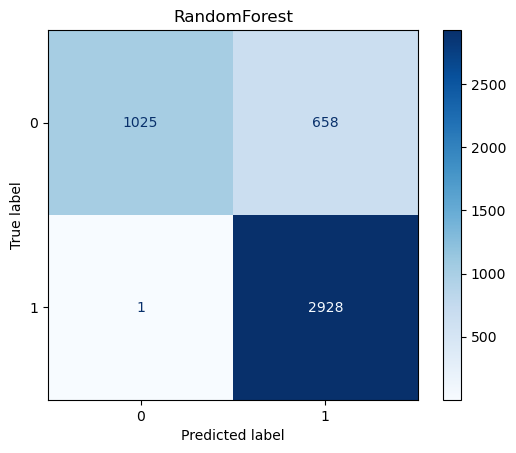

              precision    recall  f1-score   support

           0       1.00      0.61      0.76      1683
           1       0.82      1.00      0.90      2929

    accuracy                           0.86      4612
   macro avg       0.91      0.80      0.83      4612
weighted avg       0.88      0.86      0.85      4612

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Results for MLPClassifier:


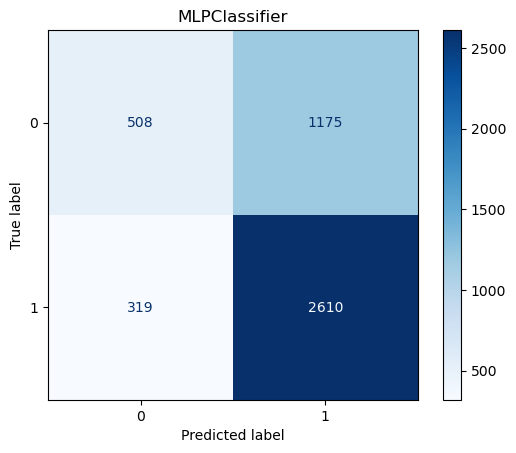

              precision    recall  f1-score   support

           0       0.61      0.30      0.40      1683
           1       0.69      0.89      0.78      2929

    accuracy                           0.68      4612
   macro avg       0.65      0.60      0.59      4612
weighted avg       0.66      0.68      0.64      4612

Best parameters: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [17]:
best_classifiers = create_best_classifiers(models, param_grid, X_scaled_train, y_scaled_train)

In [18]:
feature_importances = best_classifiers['RandomForest'].feature_importances_

# Create a DataFrame to view feature importance scores
importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.to_csv("RandomForestBestFeatures.csv", index=False)

Results for RandomForest:


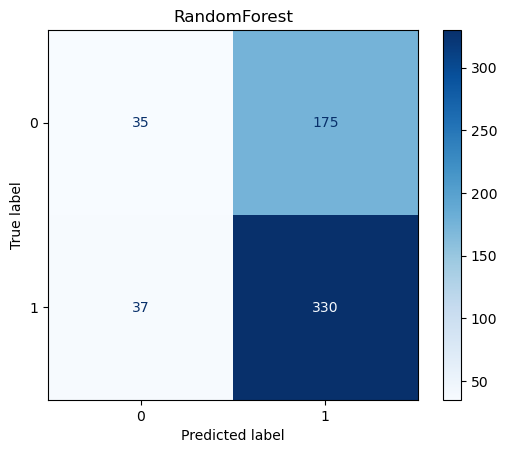

              precision    recall  f1-score   support

           0       0.49      0.17      0.25       210
           1       0.65      0.90      0.76       367

    accuracy                           0.63       577
   macro avg       0.57      0.53      0.50       577
weighted avg       0.59      0.63      0.57       577

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Results for MLPClassifier:


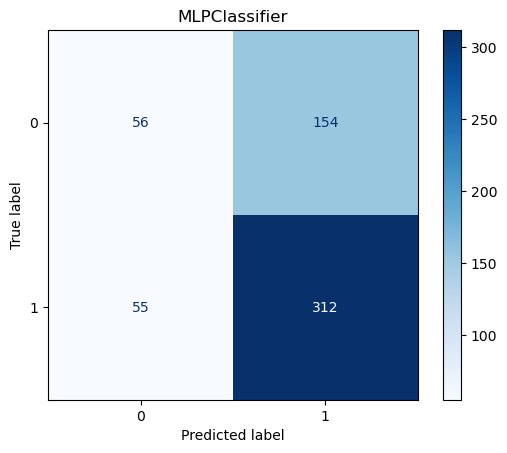

              precision    recall  f1-score   support

           0       0.50      0.27      0.35       210
           1       0.67      0.85      0.75       367

    accuracy                           0.64       577
   macro avg       0.59      0.56      0.55       577
weighted avg       0.61      0.64      0.60       577

Best parameters: {'activation': 'logistic', 'alpha': 0.1, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [19]:
evaluate_models(best_classifiers, X_scaled_eval, y_scaled_eval)

In [20]:
predict_test(best_classifiers, test_df_id, X_scaled_test, "Part3", record=True)